In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import math
import numpy as np
import cmdstanpy
import pandas as pd
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats

from plots import plot_posterior_time_series
from measurements import form_table, display_measurements
from distributions import plot_invgammas
import samples

# matplotlib.style.use('seaborn-poster')
matplotlib.style.use('ggplot')

## Population info

In [2]:
# worldometer.com, just took the current ones.  these numbers can be pretty approximate.
populations = {
    'Italy':60488135,
    'China':1435000000,
    'Korea, South':51256309,
    'Spain':46749498,
    'US':331002651,
    'Australia':25411689,
    'Iran':83671720,
    'France':65231249,
    'Germany':83706861,
    'India':1376085273,
    'Russia':145916728,
}

# Fetch the latest data on the epidemic

In [3]:
curl = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
durl = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
rurl = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

confirmed = pd.read_csv(curl, error_bad_lines=False)
dead = pd.read_csv(durl, error_bad_lines=False)
recovered = pd.read_csv(rurl, error_bad_lines=False)

data_start_index = '1/22/20'

Let's check out some of the earliest data sets.

In [4]:
def subset_country_names(table, countries):
    rose = []
    for country in countries:
        rose.append(confirmed[confirmed['Country/Region'] == country])
    return pd.concat(rose, axis=0)

subset_country_names(confirmed, ['Italy', 'Spain', 'Korea, South', 'Iran'])

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20
16,NaN,Italy,43.0,12.0,0,0,0,0,0,0,...,9172,10149,12462,12462,17660,21157,24747,27980,31506,35713
18,NaN,Spain,40.0,-4.0,0,0,0,0,0,0,...,1073,1695,2277,2277,5232,6391,7798,9942,11748,13910
156,NaN,"Korea, South",36.0,128.0,1,1,2,2,3,4,...,7478,7513,7755,7869,7979,8086,8162,8236,8320,8413
155,NaN,Iran,32.0,53.0,0,0,0,0,0,0,...,7161,8042,9000,10075,11364,12729,13938,14991,16169,17361


# Modelling one country at a time

## Extracting the time-series values

Here we'll pull out just the measurements we have for the specified country and organize them as a single matrix to feed into Stan.

# The actual model

Start with a configuration

In [18]:
data_config = {
    'start_index':data_start_index,
    'start_at_infections':50,
    'start_at_deaths':5,
    'country':'US',
}

In [19]:
measurements = form_table(data_config, confirmed, recovered, dead)
day_count = measurements.shape[0]

US reached 50 "Confirmed" on 2/24/20; dropping preceding data


It's always a good idea to take a look at the data we plan to fit to.

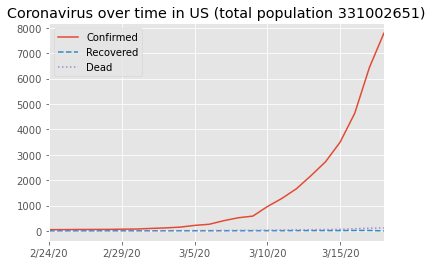

In [20]:
display_measurements(measurements, populations, data_config['country'])

If you plot an early country, you can clearly see the point at which the behavior change caused an inflection point in infections.

## MCMC sampling

The first step is to arrange the data plus a bit of metadata information for the model so that we can pass it to Stan.

It's handy to be able to visualize a few distributions when assigning priors.

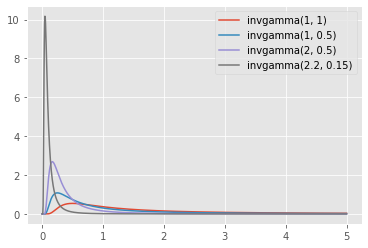

In [21]:
plot_invgammas([(1, 1), (1, 0.5), (2, 0.5), (2.2, 0.15)])

In [22]:
fit_data = {
    'y':measurements.to_numpy(),
    'T':day_count,
    'ts':list(range(0, day_count)),
    'population':populations[data_config['country']],
    # inverse gamma
    'sigma_infected_prior':[2, 0.5],
    # inverse gamma
    'sigma_dead_prior':[2, 0.5],
    # inverse gamma
    'beta_prior':[2.2, 0.15],
    # normal
    'gamma_prior':[0, 0.1],
    # normal
    'zeta_prior':[0, 0.1],
    # normal
    'skew_prior':[0, 2],
}

Now kick off the sampler.  Note the options commented below.

In [23]:
model = cmdstanpy.CmdStanModel(stan_file='sird_skewed_noise.stan')

fit = model.sample(data=fit_data,
                   # output_dir='.',
                   # show_progress='notebook',
                   # Use a fixed seed so that our runs are deterministic.
                   seed=2222,
                   # This computer has 24 cores/48 threads; 24 chains is plenty
                   cores=24,
                   chains=24,
                   # Make the sampler a bit more robust in exchange for more sampling time
                   # adapt_delta=0.95,
                   # Let the sampler explore deeper
                   # max_treedepth=12,
                   # Make sure to get enough samples to avoid any diagnostic problems
                   iter_sampling=300)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/peddie/programming/covid19-modelling/sird_skewed_noise
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:start chain 5
INFO:cmdstanpy:start chain 6
INFO:cmdstanpy:start chain 7
INFO:cmdstanpy:start chain 8
INFO:cmdstanpy:start chain 9
INFO:cmdstanpy:start chain 10
INFO:cmdstanpy:start chain 11
INFO:cmdstanpy:start chain 12
INFO:cmdstanpy:start chain 13
INFO:cmdstanpy:start chain 14
INFO:cmdstanpy:start chain 15
INFO:cmdstanpy:start chain 16
INFO:cmdstanpy:start chain 17
INFO:cmdstanpy:start chain 18
INFO:cmdstanpy:start chain 19
INFO:cmdstanpy:start chain 20
INFO:cmdstanpy:start chain 21
INFO:cmdstanpy:start chain 22
INFO:cmdstanpy:start chain 23
INFO:cmdstanpy:start chain 24
INFO:cmdstanpy:finish chain 14
INFO:cmdstanpy:finish chain 6
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 22
INFO:cmdstanpy:fi

### Check the run

We'll pull up a few initial diagnostics.  If any warnings show up here, we should probably change the run parameters and resample.

In [24]:
important_values = (
    'lp__',
    'beta',
    'gamma',
    'zeta',
    'sigma_infected',
    'sigma_dead',
    'skew',
) 
samples.run_validate_stan(fit, important_values)

INFO:cmdstanpy:Processing csv files: /tmp/tmpshrc1cv9/sird_skewed_noise-202003191822-1-kn4g8465.csv, /tmp/tmpshrc1cv9/sird_skewed_noise-202003191822-2-5vl0_t8r.csv, /tmp/tmpshrc1cv9/sird_skewed_noise-202003191822-3-tfltlk6z.csv, /tmp/tmpshrc1cv9/sird_skewed_noise-202003191822-4-c2cvlpno.csv, /tmp/tmpshrc1cv9/sird_skewed_noise-202003191822-5-c68e07z1.csv, /tmp/tmpshrc1cv9/sird_skewed_noise-202003191822-6-823rbl62.csv, /tmp/tmpshrc1cv9/sird_skewed_noise-202003191822-7-zku85q8k.csv, /tmp/tmpshrc1cv9/sird_skewed_noise-202003191822-8-gj_qwb8w.csv, /tmp/tmpshrc1cv9/sird_skewed_noise-202003191822-9-yfas0lo2.csv, /tmp/tmpshrc1cv9/sird_skewed_noise-202003191822-10-2yq_n6nm.csv, /tmp/tmpshrc1cv9/sird_skewed_noise-202003191822-11-oe_16w8b.csv, /tmp/tmpshrc1cv9/sird_skewed_noise-202003191822-12-d9x0hzxh.csv, /tmp/tmpshrc1cv9/sird_skewed_noise-202003191822-13-xxuqpftp.csv, /tmp/tmpshrc1cv9/sird_skewed_noise-202003191822-14-5a5k0uug.csv, /tmp/tmpshrc1cv9/sird_skewed_noise-202003191822-15-bzrqfg0c.cs

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-219.362000,0.038580,1.888400,-222.904000,-218.964000,-217.072000,2395.90,348.661,1.00542
beta,0.218957,0.000093,0.004760,0.210159,0.219552,0.225613,2644.02,384.769,1.00754
gamma,0.000486,0.000001,0.000098,0.000340,0.000479,0.000661,5185.56,754.624,1.00177
zeta,0.004764,0.000007,0.000400,0.004154,0.004739,0.005468,3747.50,545.352,1.00418
sigma_infected,0.377034,0.000726,0.053802,0.300094,0.371133,0.473615,5486.43,798.407,1.00114
sigma_dead,0.293071,0.000467,0.032650,0.244721,0.290129,0.351398,4897.71,712.734,1.00172
skew,2.212410,0.018134,1.123410,0.673337,2.028590,4.328030,3837.93,558.511,1.00333


## Posterior plotting

Now it's time to see what we got in terms of time series samples.

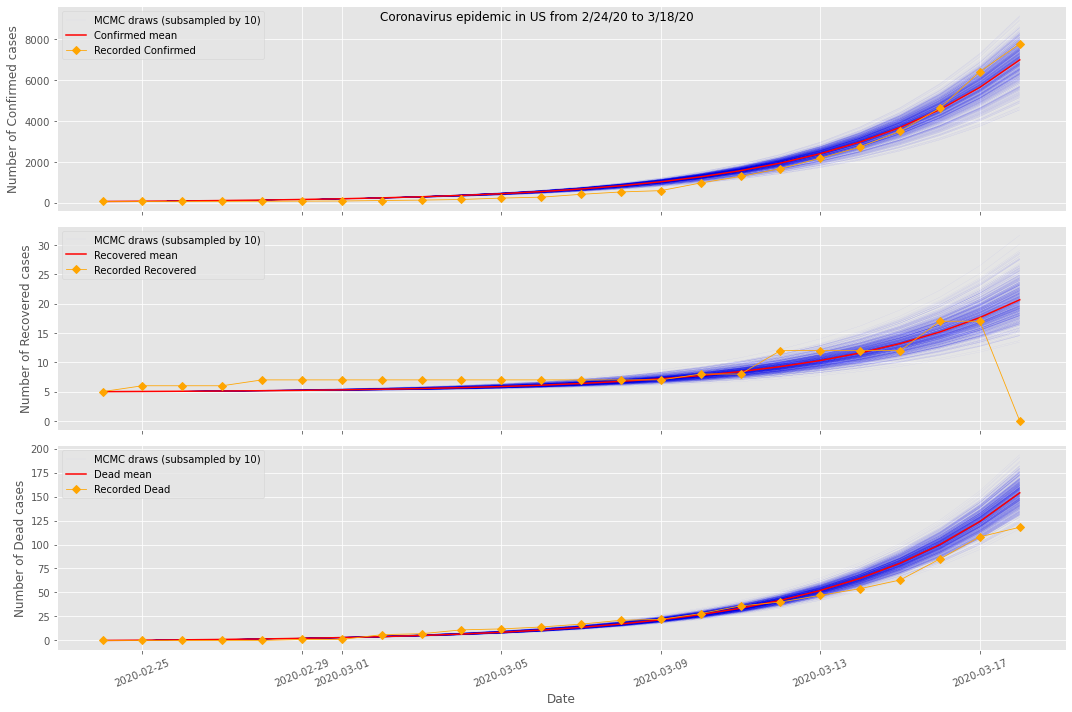

In [25]:
yhat_samples = samples.get_sample_time_series(fit)
plot_posterior_time_series(yhat_samples, measurements, data_config)

## Extended diagnostics

We'll use arviz to do some more diagnostic plots.

In [26]:
inferred = az.from_cmdstanpy(fit, 
                             log_likelihood='log_likelihood',
                             posterior_predictive='y_hat',
                             observed_data={'y':measurements.to_numpy()})

# TODO(MP): how do you plot log probability of the sample?  'lp__' is gone.
analysis_variables=list(filter(lambda x: x != 'lp__', important_values))

### Posterior correlation plots

What is going on with gamma and beta?

/usr/local/lib/python3.8/dist-packages/arviz/plots/backends/matplotlib/pairplot.py:129: MatplotlibDeprecationWarning: In a future version, 'pad' will default to rcParams['figure.subplot.wspace'].  Set pad=0 to keep the old behavior.
  cax = divider.append_axes("left", size="7%")


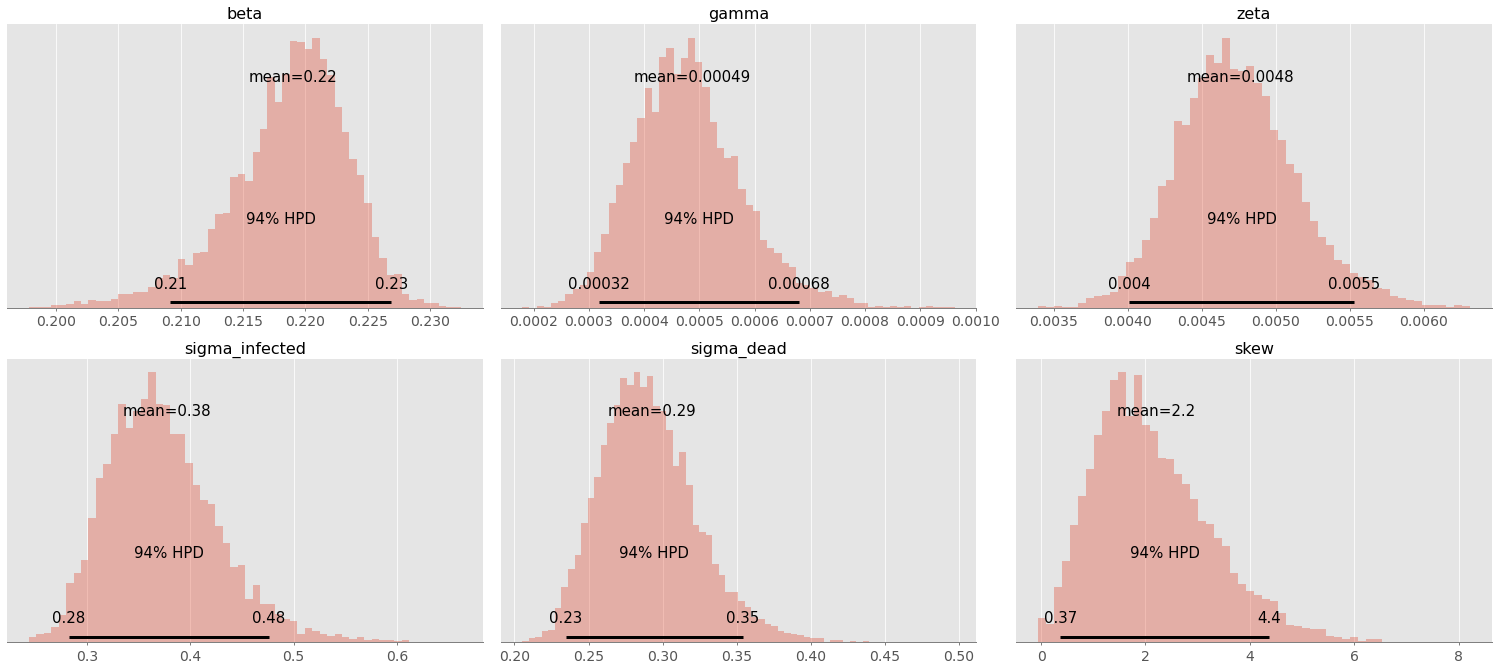

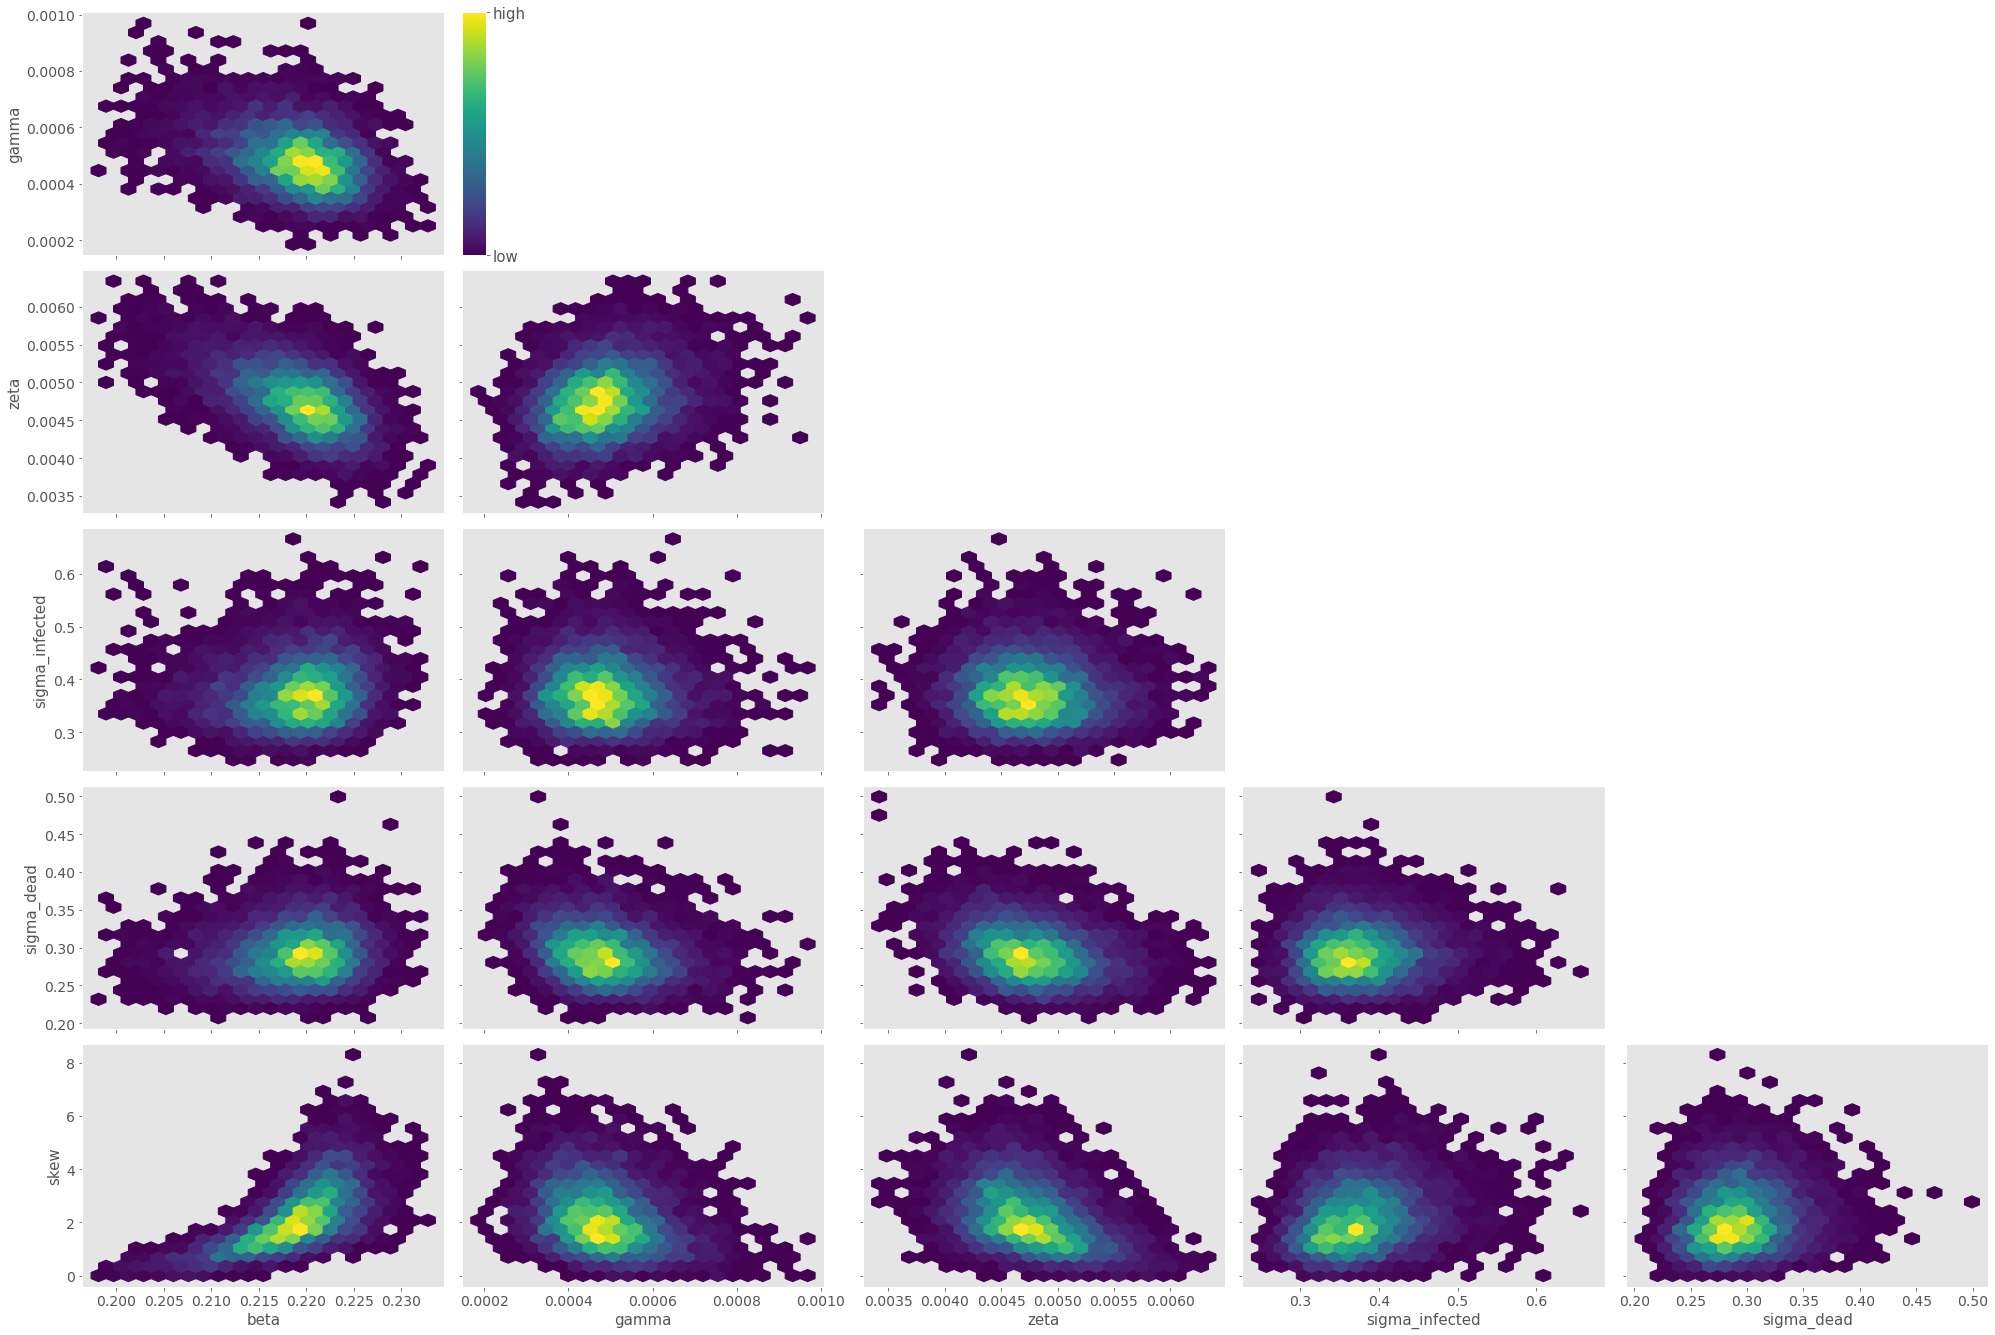

In [27]:
samples.param_posterior_arviz_plots(inferred, analysis_variables)

LOO analysis:
 Computed from 7200 by 72 log-likelihood matrix

         Estimate       SE
elpd_loo  -279.00    19.92
p_loo        4.66        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       72  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



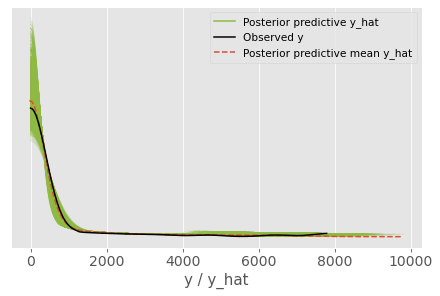

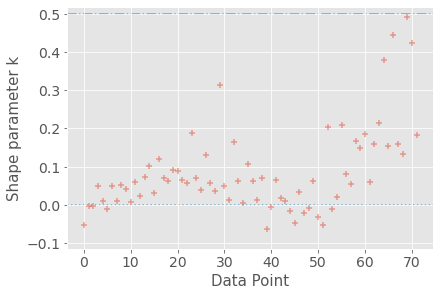

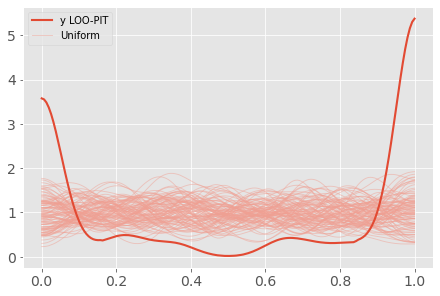

In [28]:
_ = samples.run_validate_arviz(inferred)

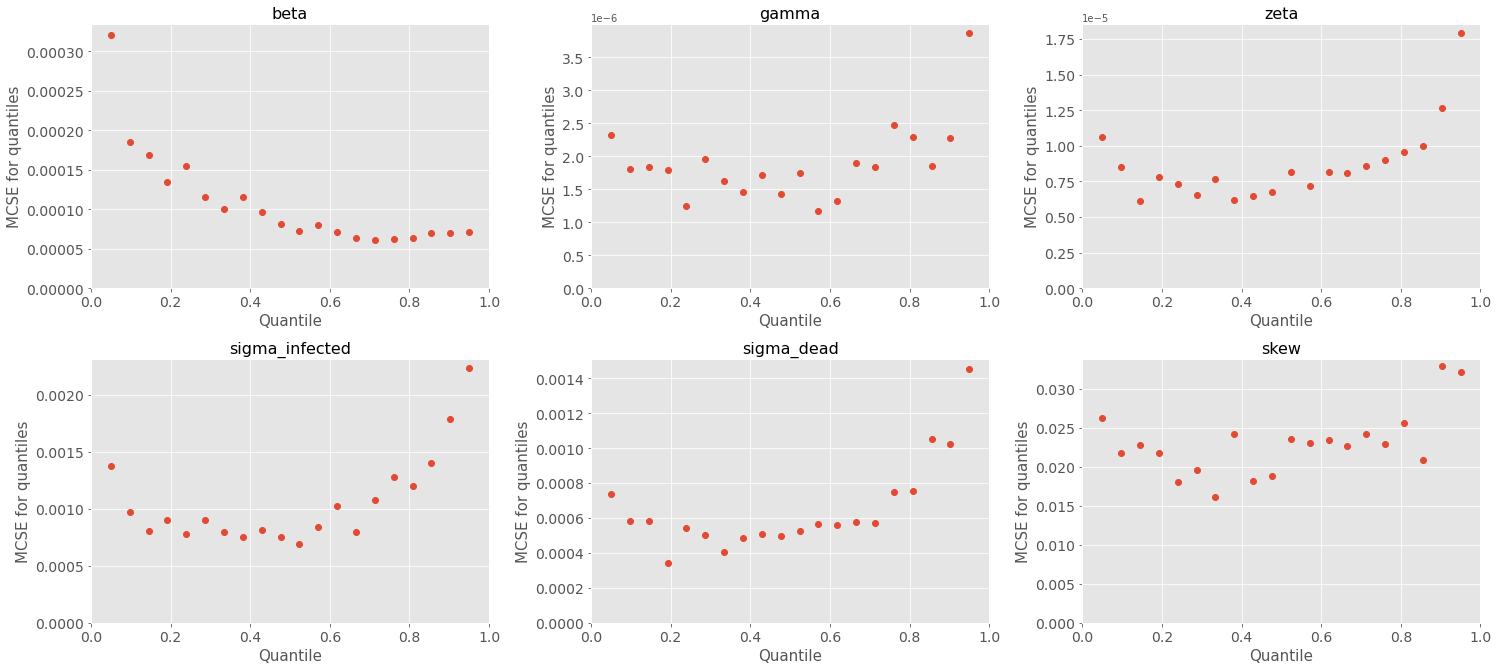

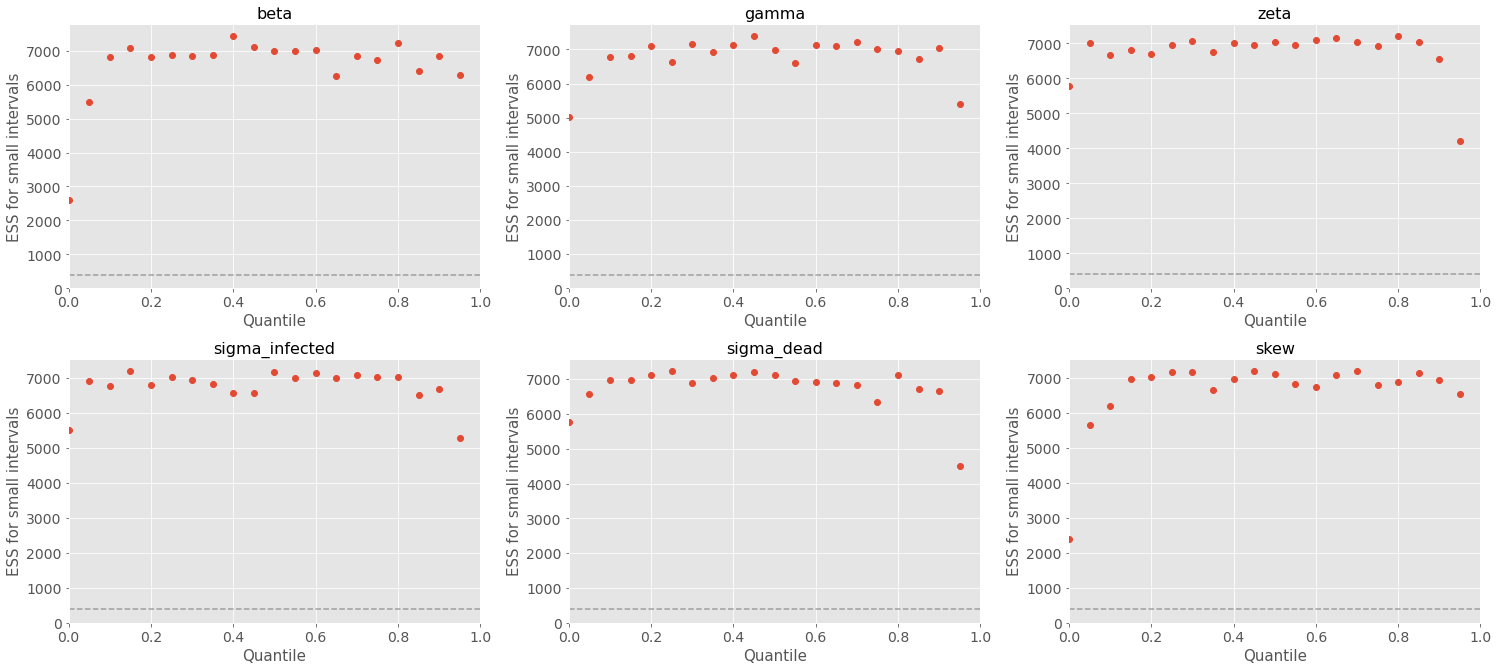

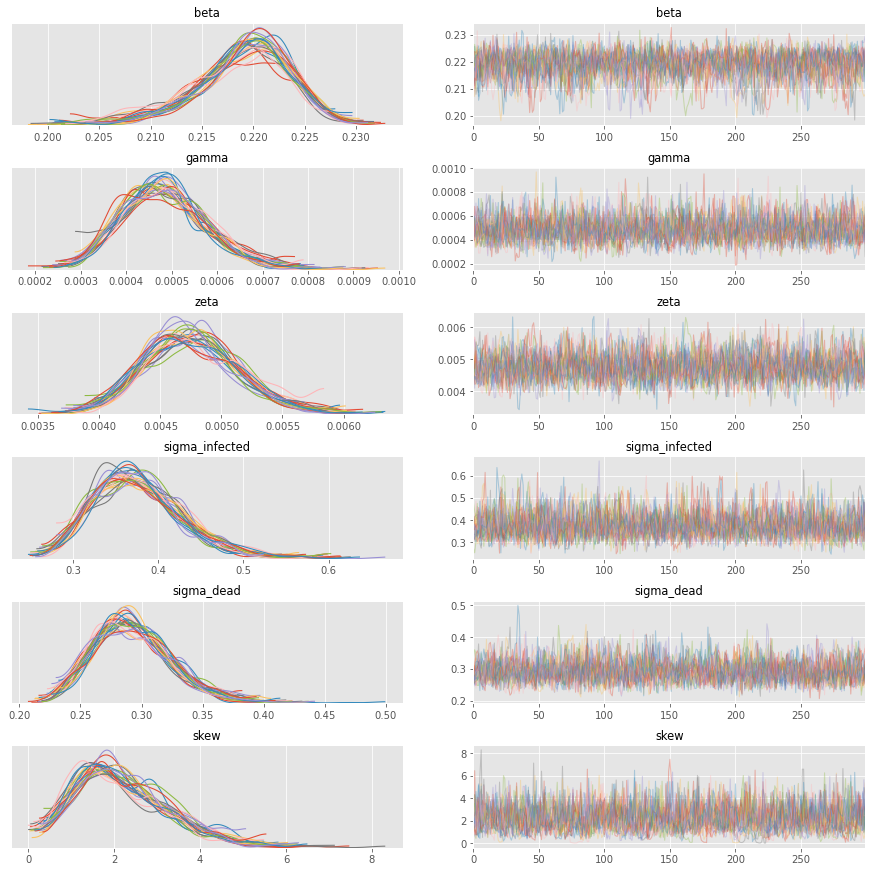

In [29]:
samples.param_validate_arviz(inferred, analysis_variables)

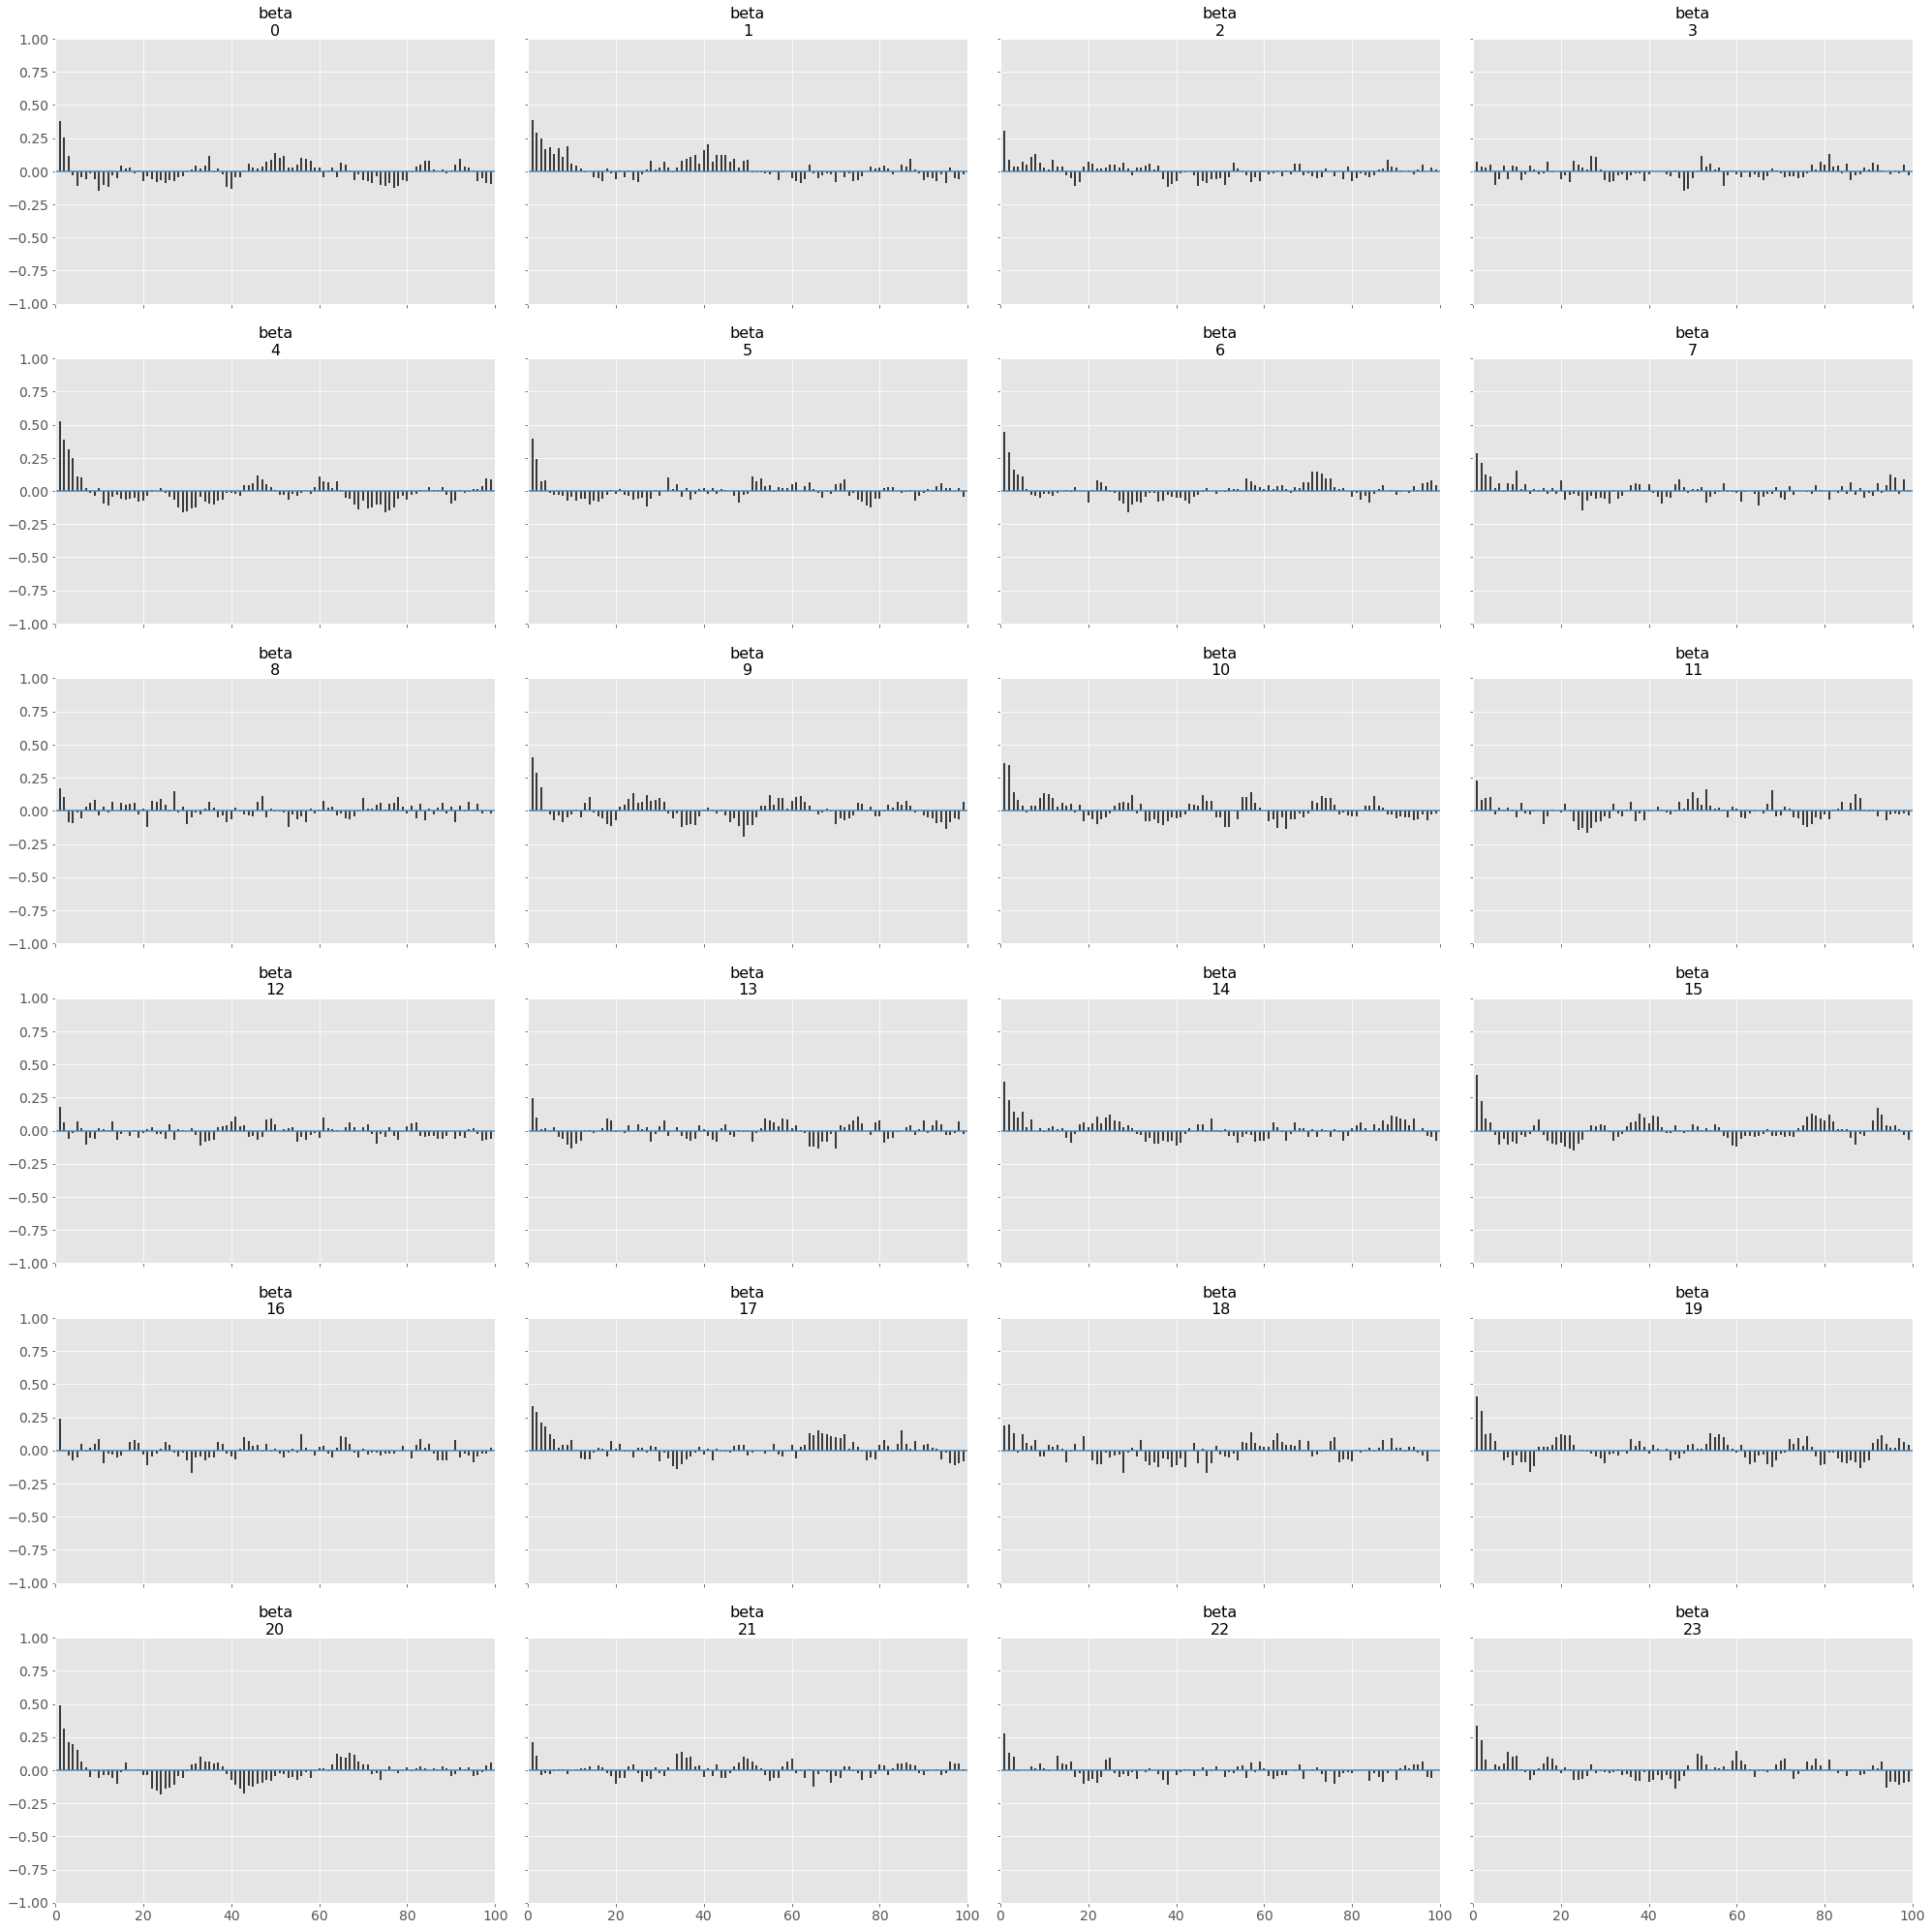

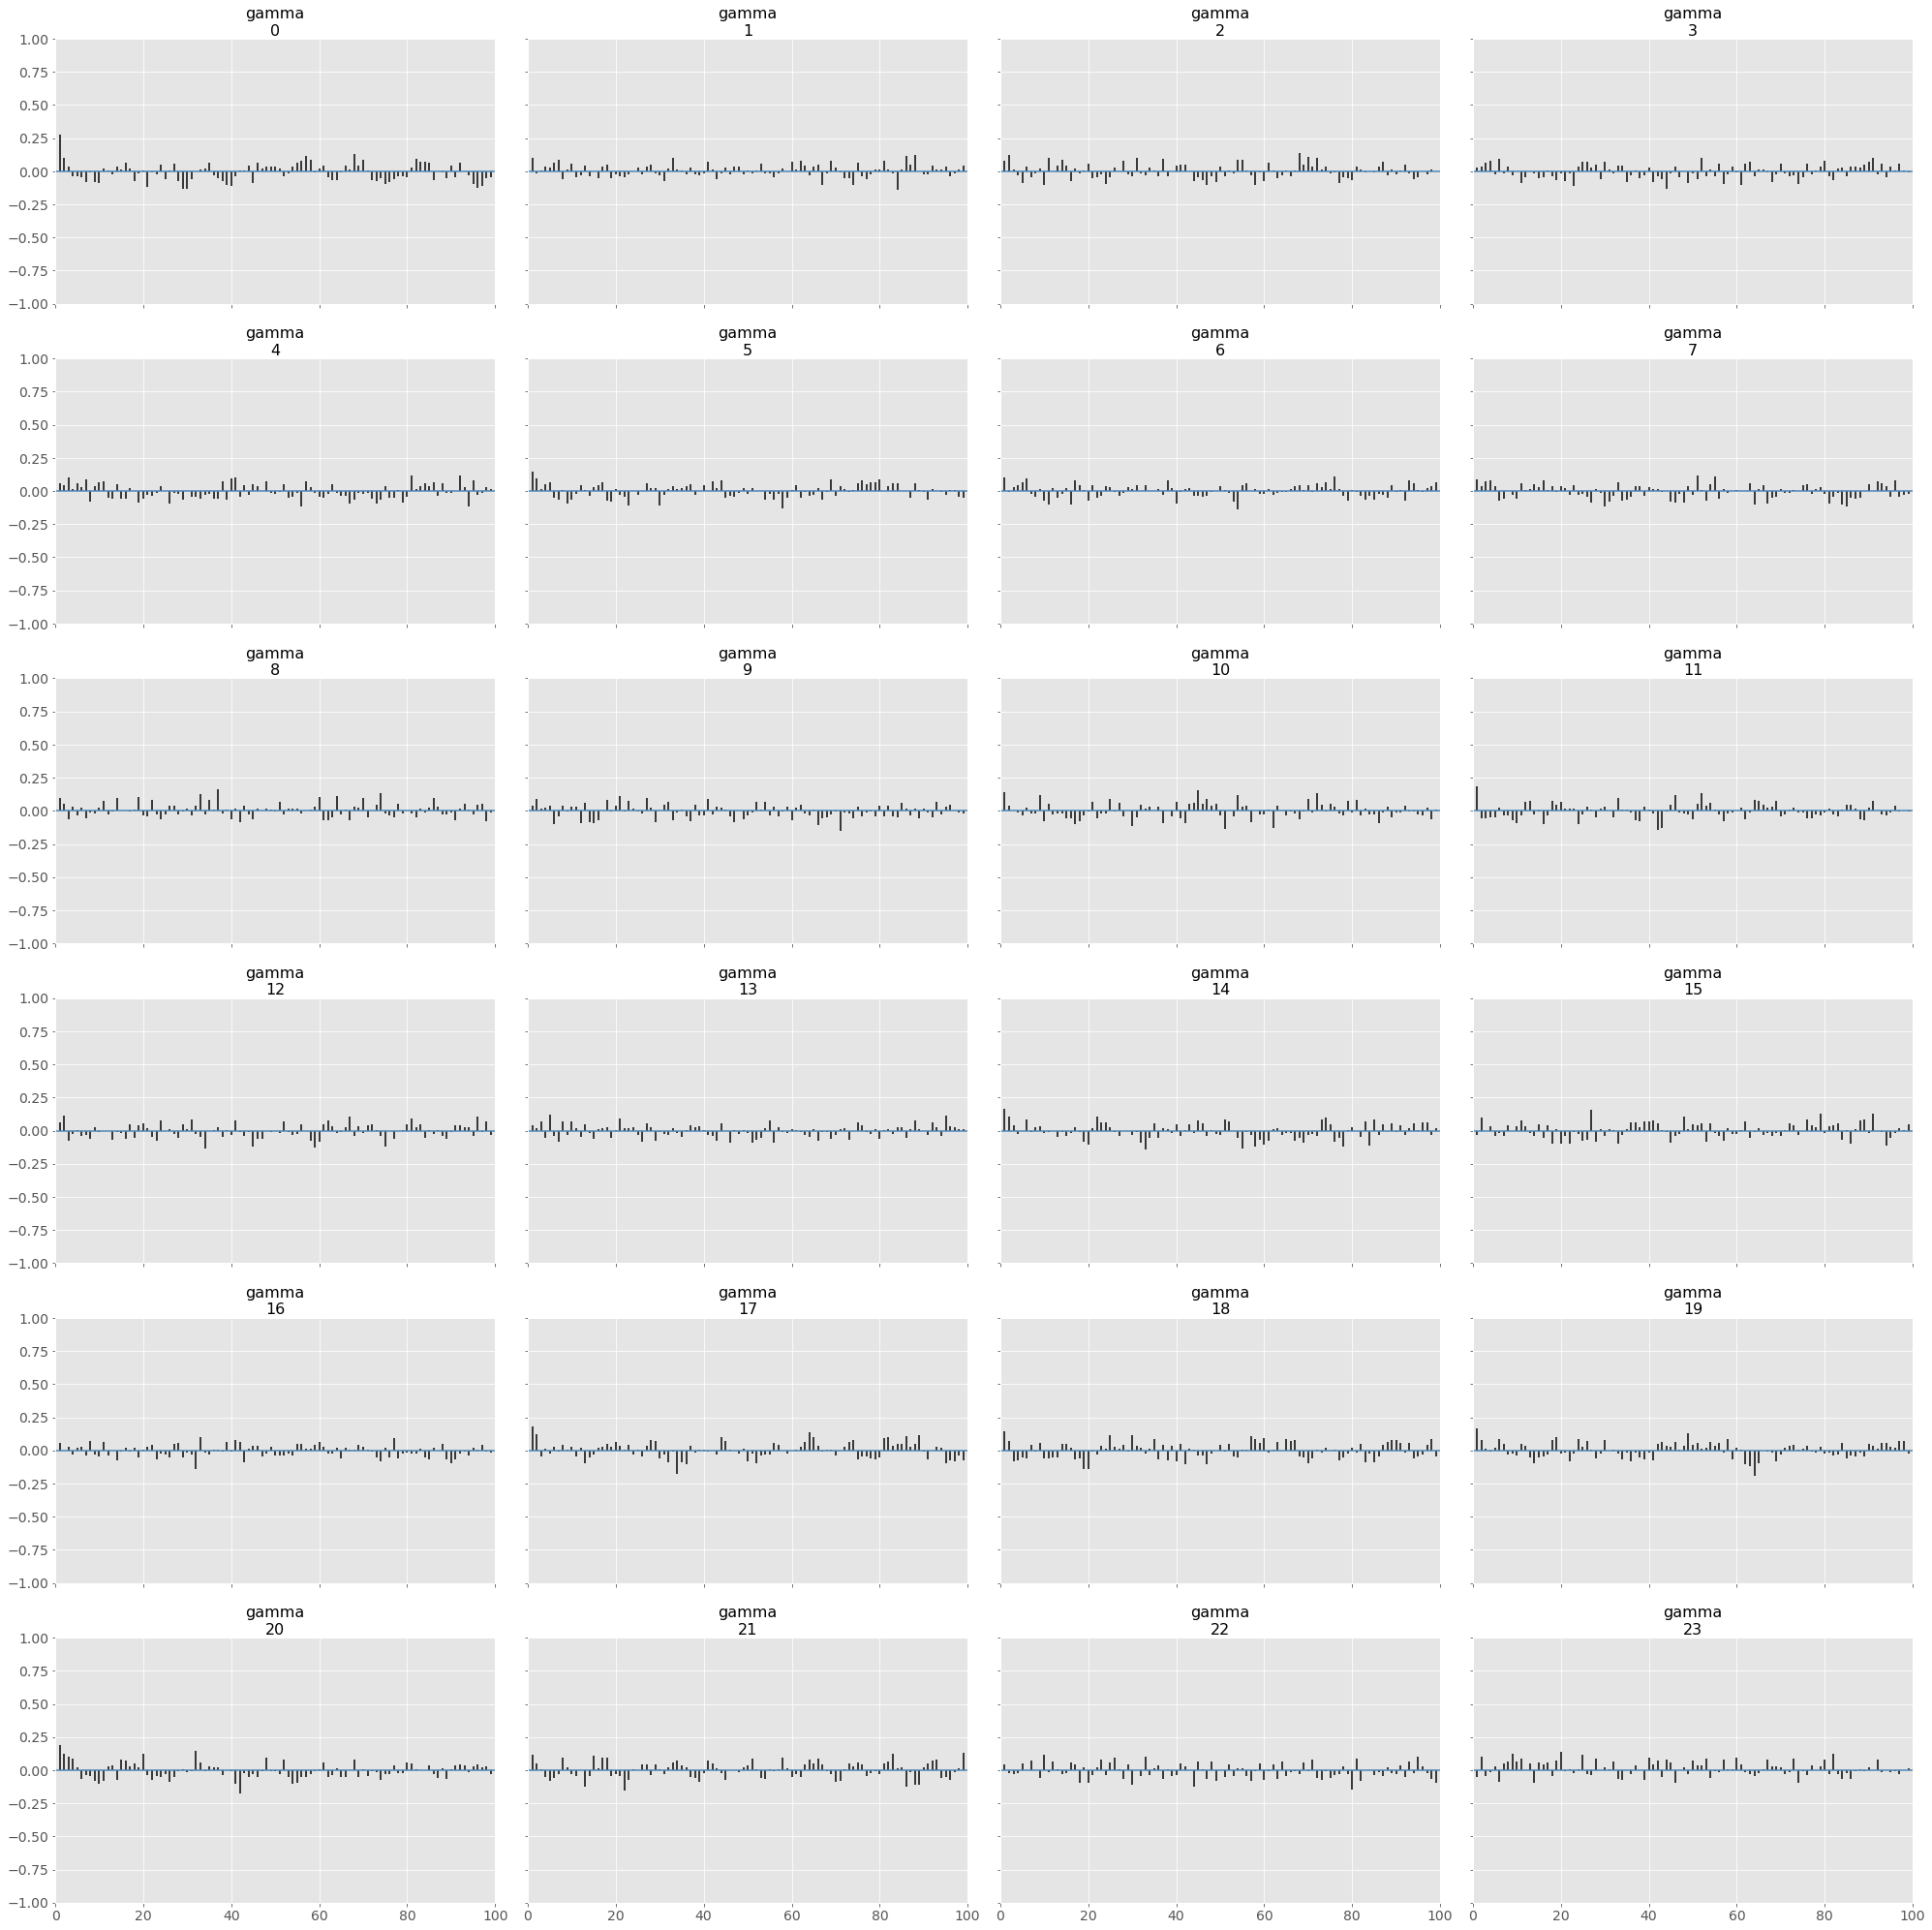

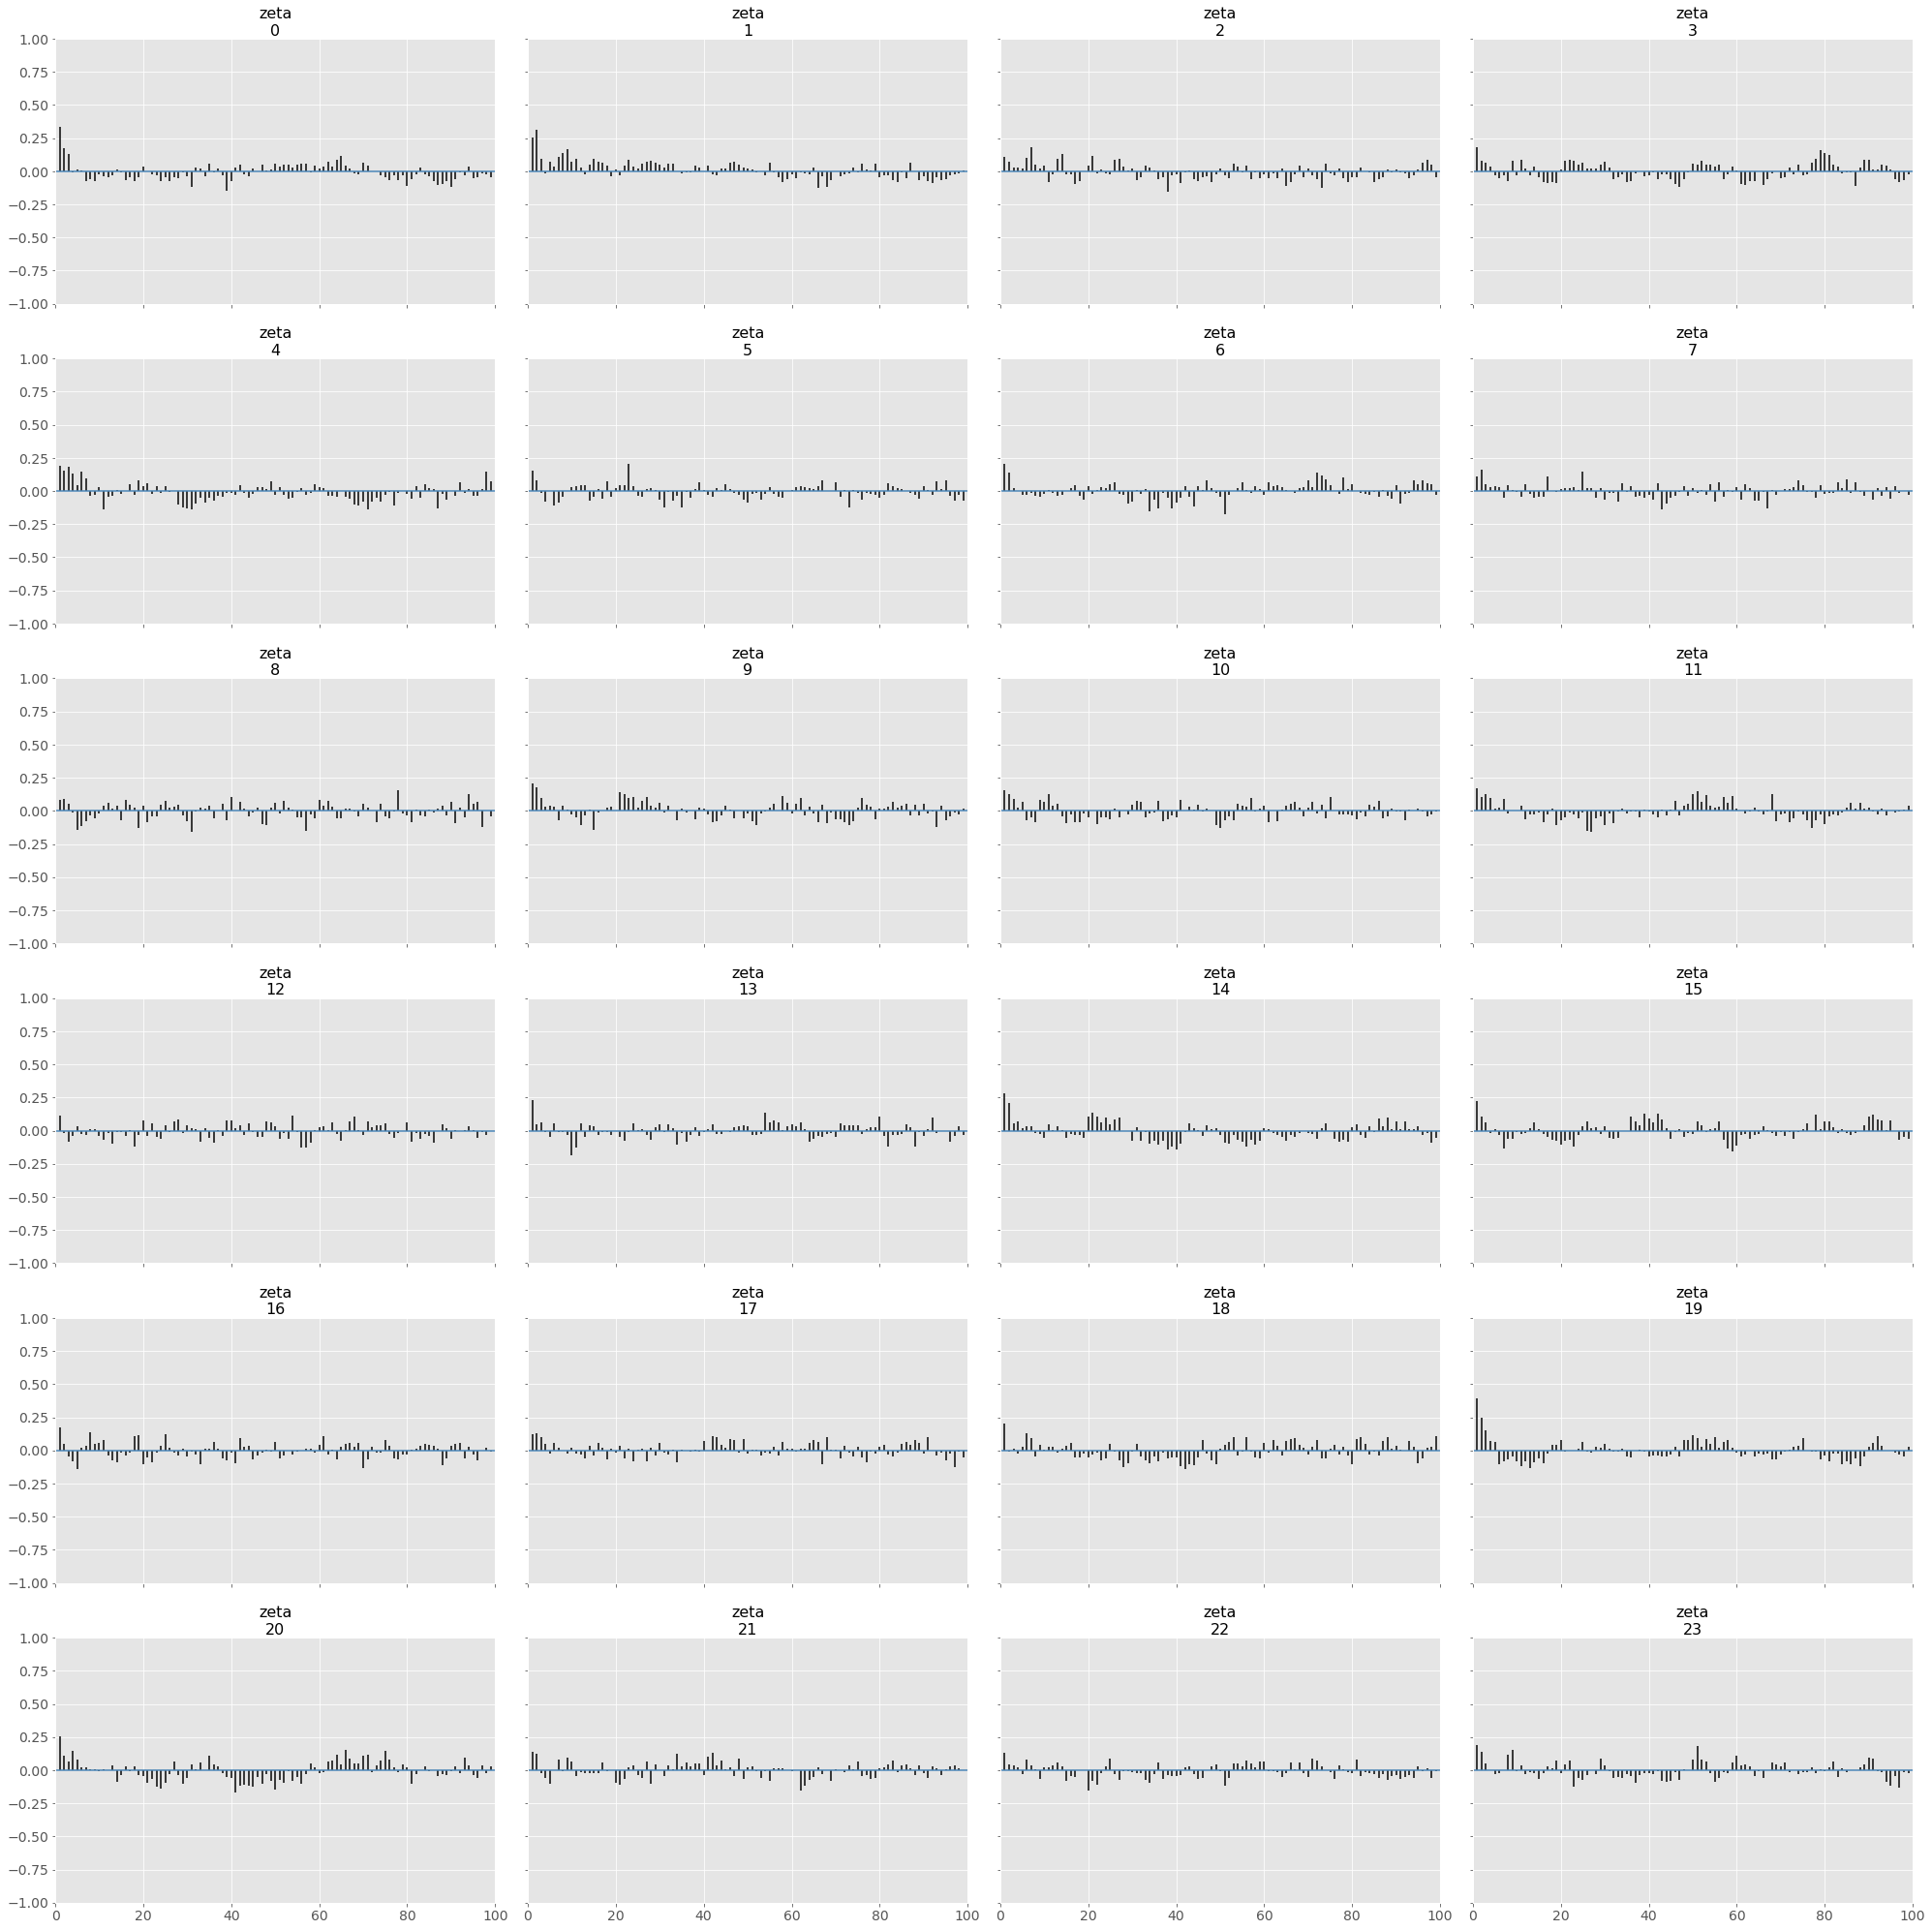

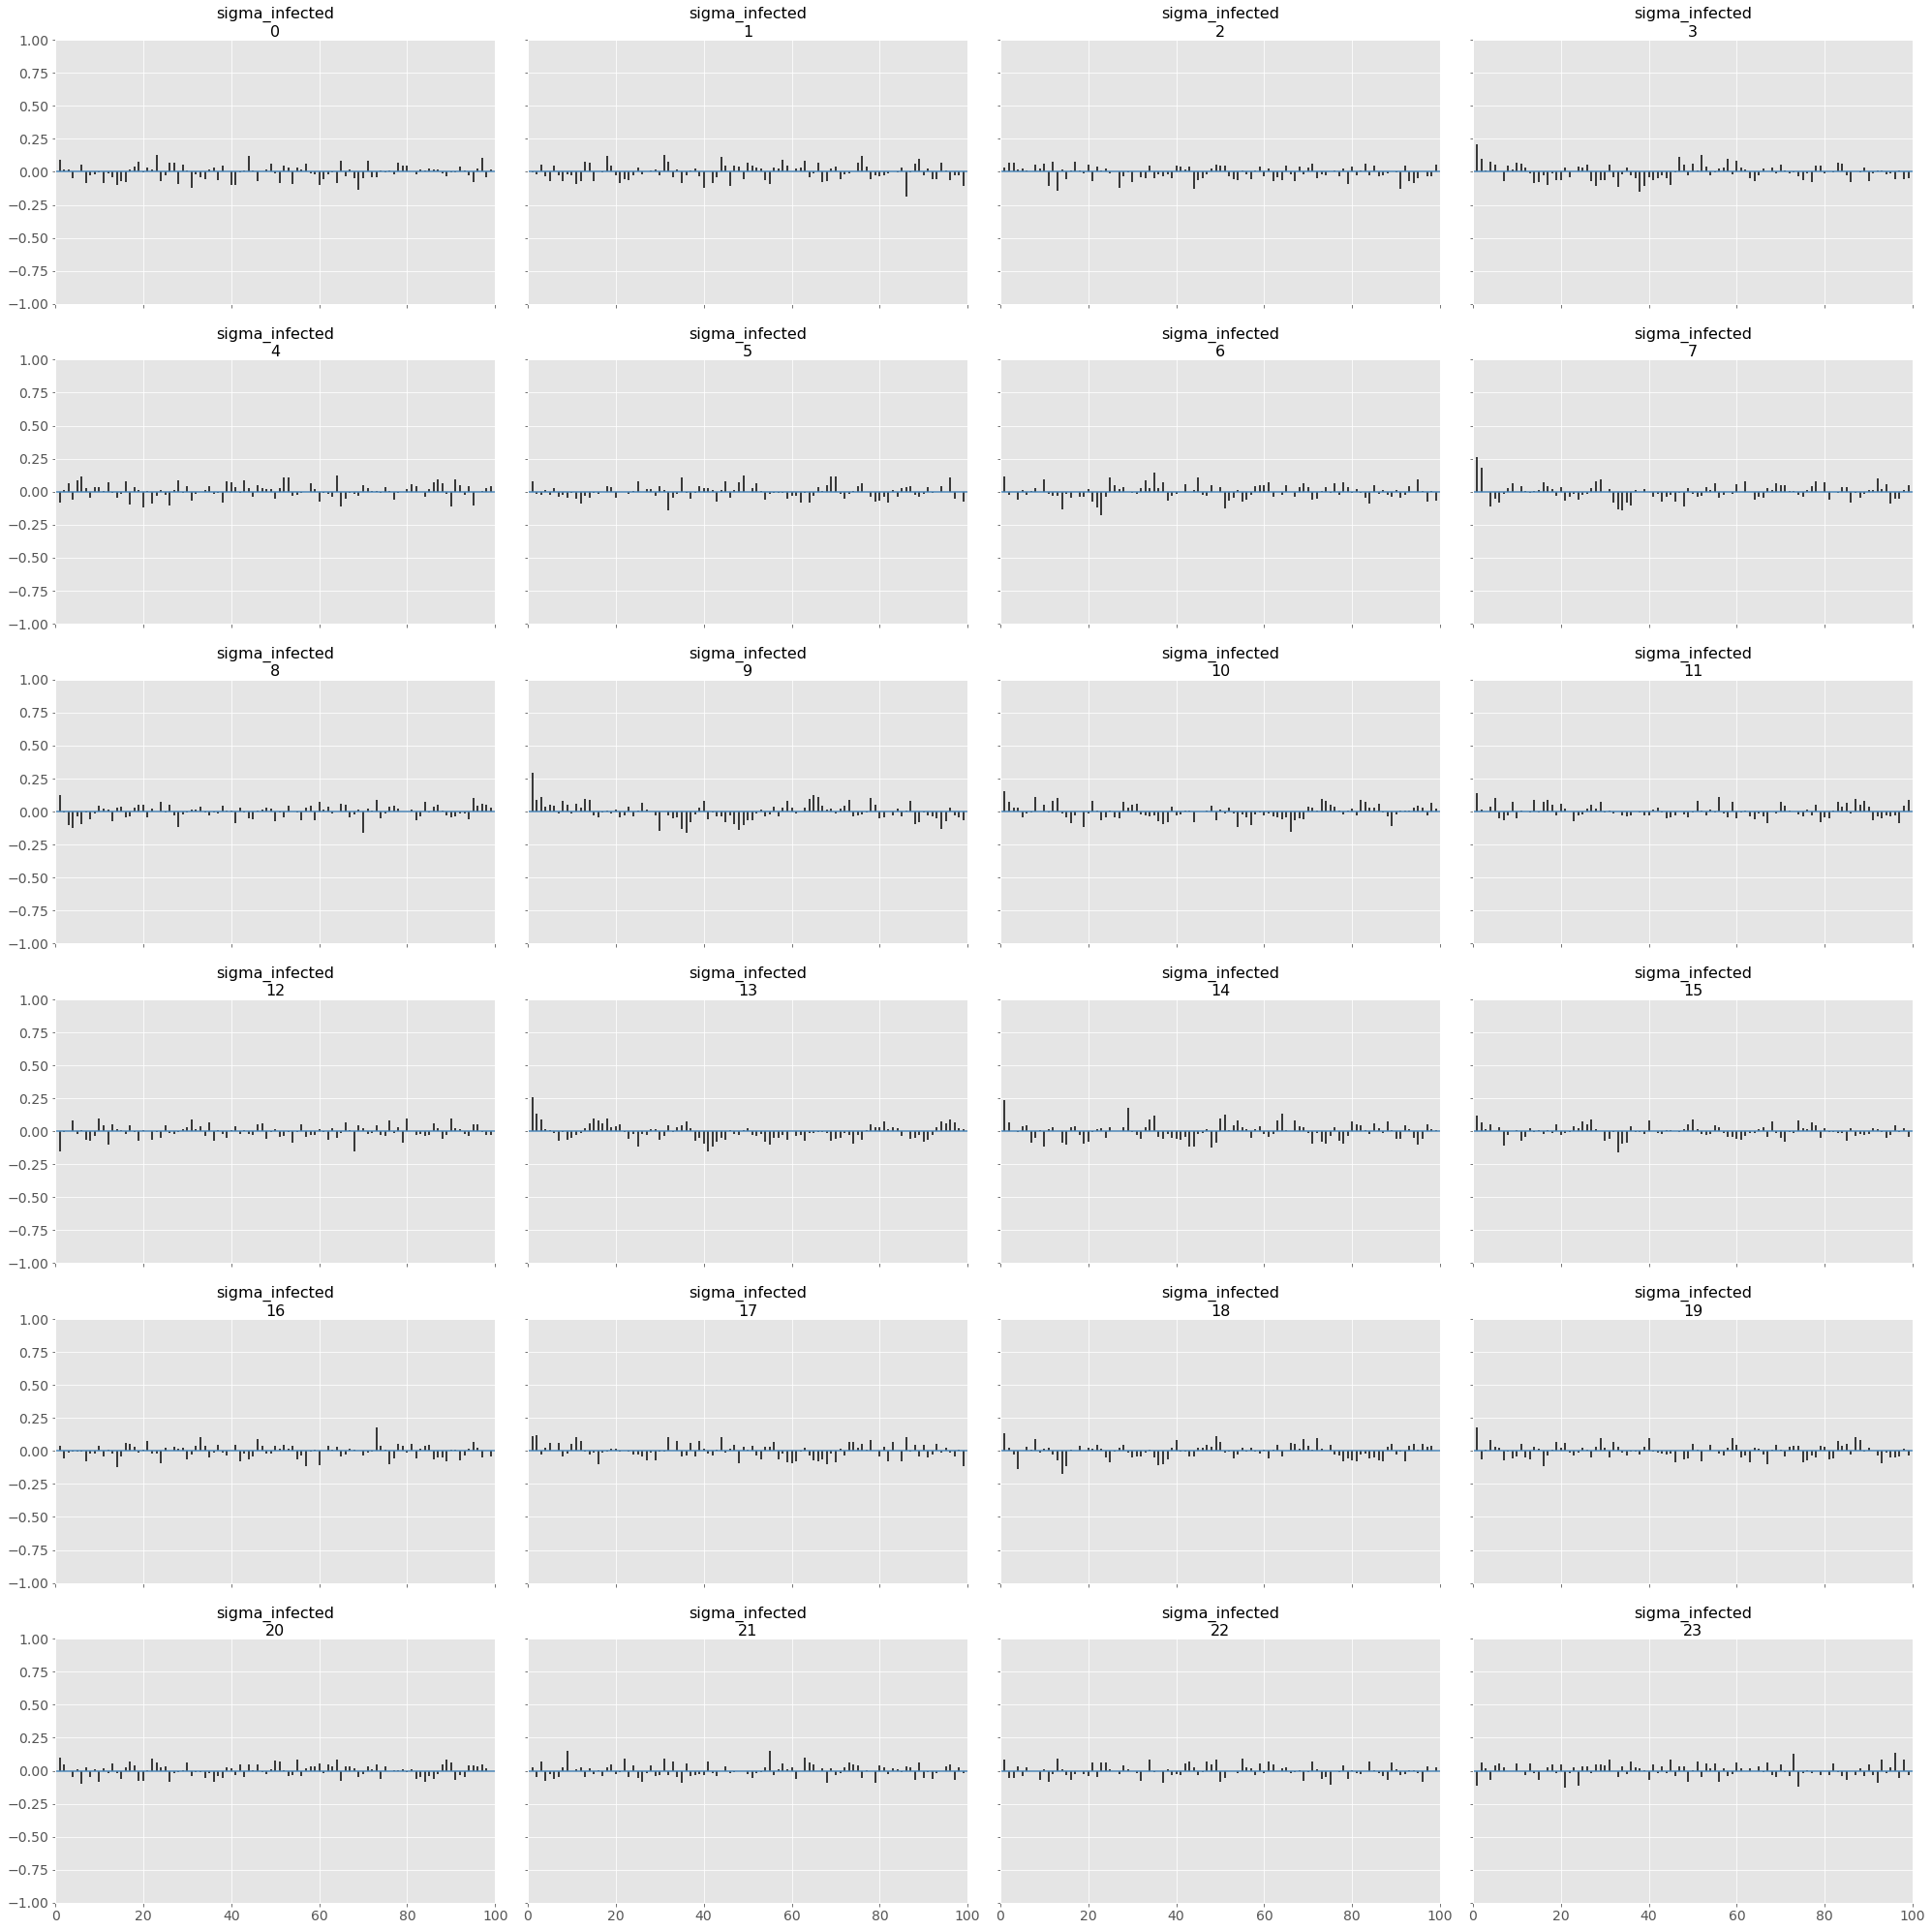

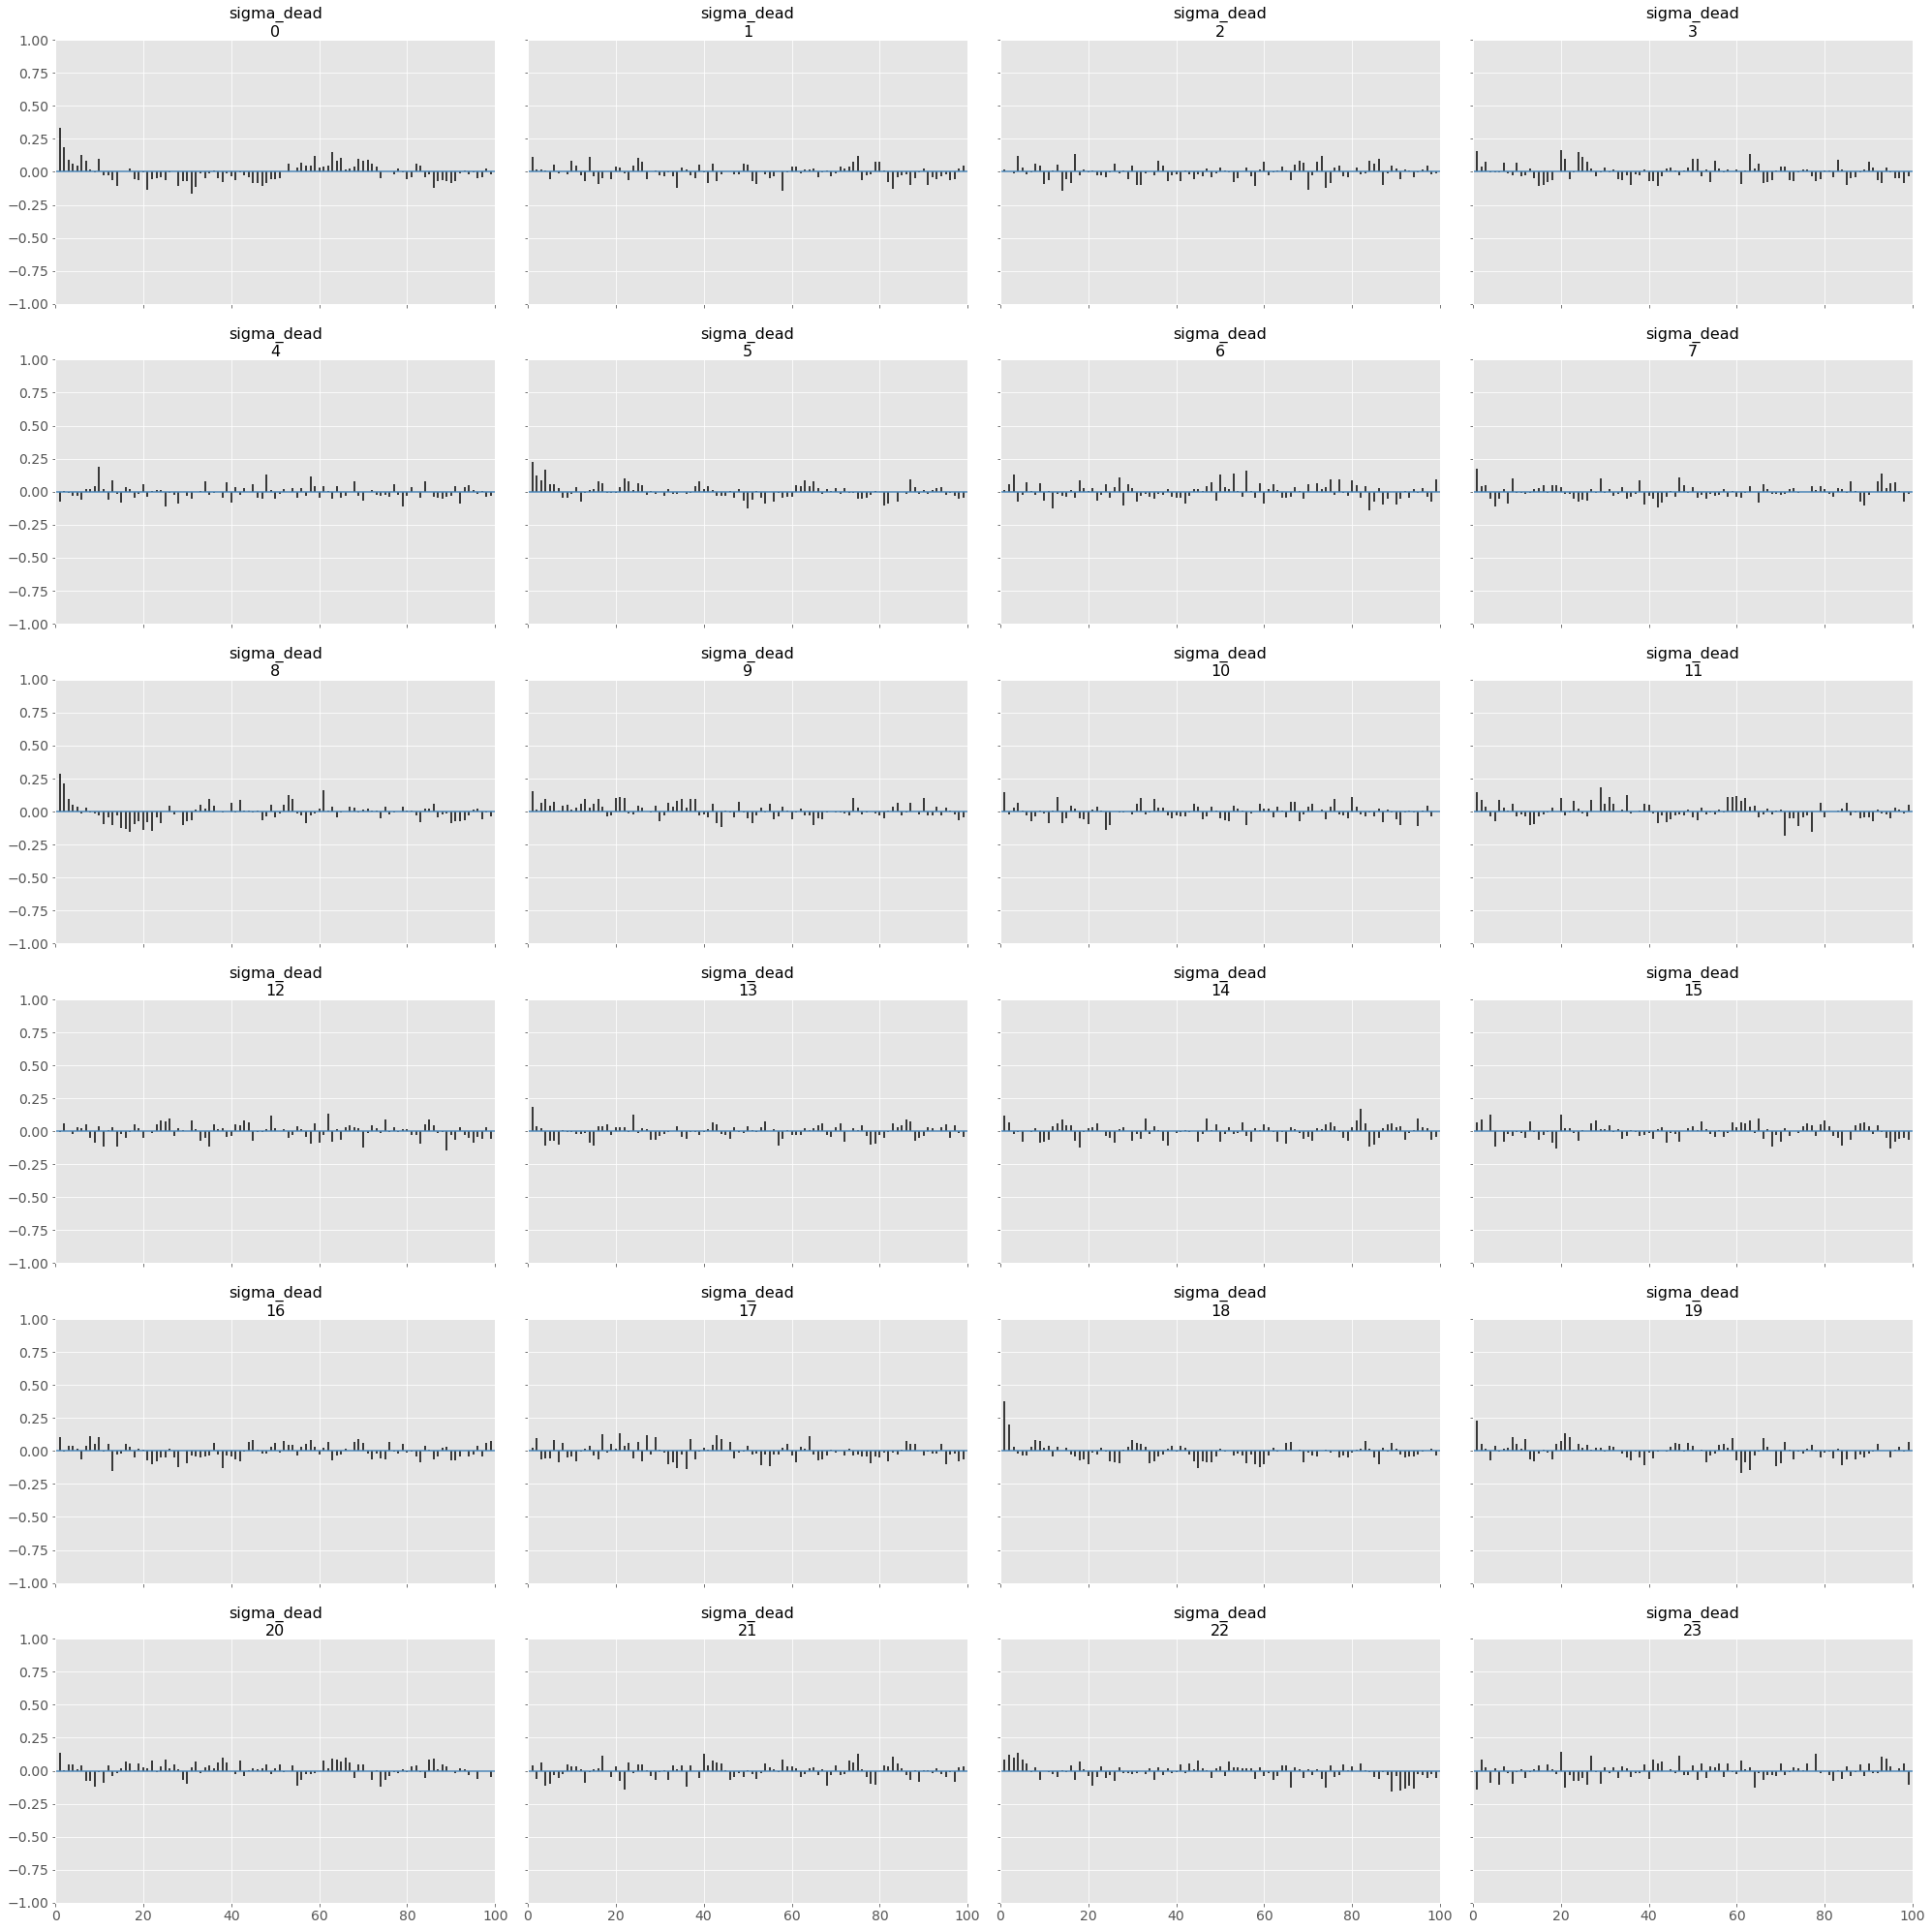

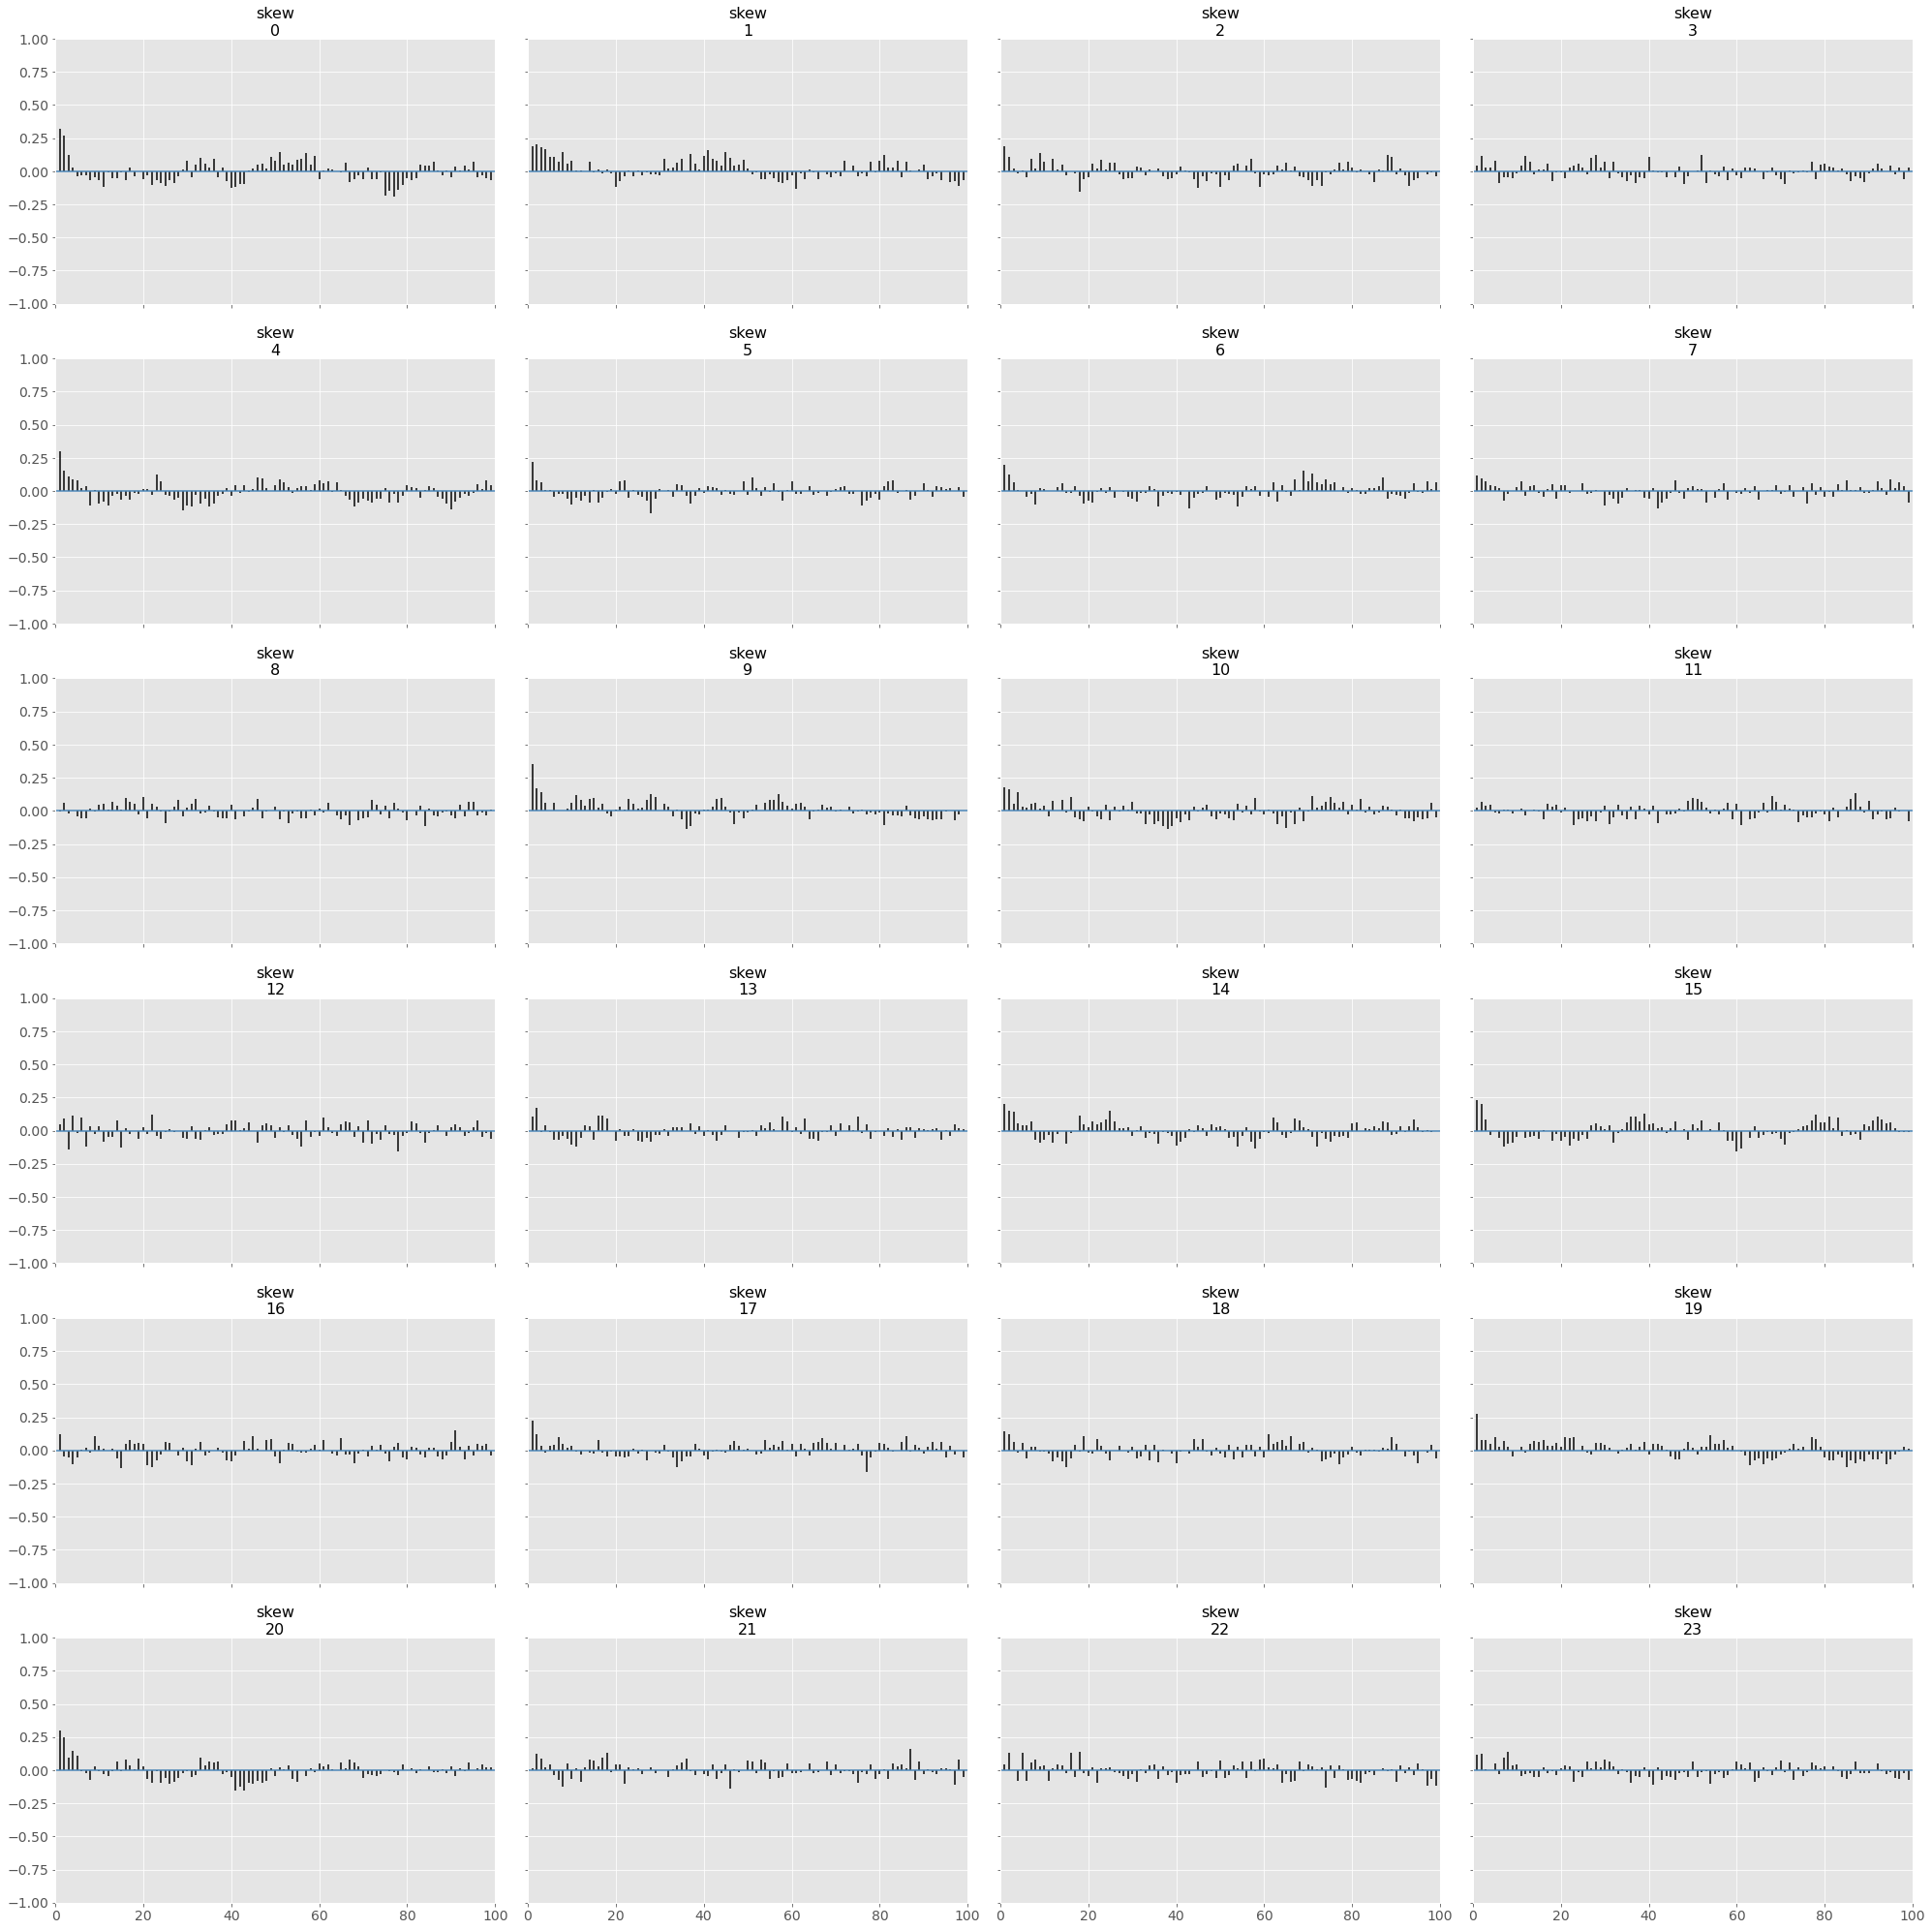

In [30]:
samples.chain_validate_arviz(inferred, analysis_variables)